# Frame The Problem

Our source for our data is the CIFAR-10 dataset gotten from https://www.cs.toronto.edu/~kriz/cifar.html.

# Frame The Problem
1. **Define the objective in business terms.**
- We have been hired by the National Wildlife Service, they have cameras they want to use to track staple wild animal populations, specifically birds, deer, and frogs, with their cameras and statistical models. Cats and dogs can also affect the environment, so they make sure people's pets do not kill off the wild animal populations. Other images of horses, airplanes, automobiles, ships, and trucks are often caught on these cameras and are of little use to the service, but they want to be tracked because some papers have suggested that noise pollution from these can affect animal and plant populations.
2. **How will your solution be used?**
- Our solution will predict what pictures are in bulk, allowing the National Wildlife Service to plug the numbers into their statistical models. The more accurate the data is, the better they will be able to predict populations. Because of the fact that they are using probabilistic math to calculate populations, even a small amount of misses can heavily skew numbers.
3. **What are the current solutions/workarounds (if any)?**
The only other ways of counting are likely to cost lots of money, employing paid park employees who could be doing more useful things, like planting trees and killing off foreign invaders.
4. **How should you frame this problem (supervised/unsupervised, online/offline, ...)?**
- The project is a supervised task, it does not need to be online because results will be checked seasonally as I said before the statistic model they used is based on probability so looking at longer periods time will increase accuracy, but there is also a delicate balance as checking how many animals come through the camera needs to allow the service to react to population lost and understand animal movement patterns to better protect the animals.
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
- Performance should be measured by precision in predicting animals because if we are able to catch the animals with no malfunction, the math can be scaled by a factor of our known failure rate. Objects other than animals are just being collected in case that data can be useful, and also because we know those are the things that are commonly picked up by our cameras.
6. **What would be the minimum performance needed to reach the business objective?**
- The problem is mainly that they are spending a lot of money labeling the pictures, a 90% precision with each wild animal should be enough for them to get a good grasp of how many animals there are in a specific region so that they can use the data to use resources in areas of most need.
8. **Is human expertise available?**
- Human expertise is not available, since every year the National Wildlife Service has to do more and more with its limited budget every year we were hired as a way to remove spending animal counters.
9. **How would you solve the problem manually?**
- They would get a bunch of people to label the pictures manually. Perhaps I could also direct them to use Amazon Turk. But I can't afford to lose this job.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**
- The animals and other objects will likely not change very much over time, and if they do, we can retraining the system will be cheap.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras
import tensorflow as tf
from functools import partial



# Get the Data

In [27]:
label_words = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

def unpickle(has_validation=True):
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3','data_batch_4']
    if has_validation:
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        data = None
        for file in files:
            with open('data/'+file, 'rb') as fo:
                data = pickle.load(fo, encoding='bytes')
                y_train += list(data[b'labels'])
                X_train += list(data[b'data'])

        with open('data/data_batch_5', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_val = list(data[b'labels'])
            X_val = list(data[b'data'])

        with open('data/test_batch', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_test = list(data[b'labels'])
            X_test = list(data[b'data'])

        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
        y_train = []
        X_train = [] 
        data = None
        for file in files:
            with open('data/'+file, 'rb') as fo:
                data = pickle.load(fo, encoding='bytes')
                y_train += list(data[b'labels'])
                X_train += list(data[b'data'])

        with open('data/test_batch', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_test = list(data[b'labels'])
            X_test = list(data[b'data'])

        return X_train, y_train, X_test, y_test
    

def plot_cifar10_images(images, labels):
    axes = plt.subplots(5, 5, figsize=(10, 10))[1]
    for i in range(5):
        for j in range(5):
            index = i * 5 + j
            image = images[index].reshape(3, 32, 32).transpose(1, 2, 0)
            axes[i, j].imshow(image)
            axes[i, j].set_title(labels[index])
            axes[i, j].axis('off')
    plt.show()

In [28]:
X_train, y_train, X_valid, y_valid, X_test, y_test = unpickle(has_validation=True)
# Reshape the data
X_train = np.array(X_train).reshape(-1, 32, 32, 3)
X_valid = np.array(X_valid).reshape(-1, 32, 32, 3)
X_test = np.array(X_test).reshape(-1, 32, 32, 3)
# Normalize the data
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0
# Reshape the labels
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


# Explore the Data

# Short Listing

In [29]:
# basic MLP
model = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    batch_size=32
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2512 - loss: 2.0454 - val_accuracy: 0.3268 - val_loss: 1.8596
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3673 - loss: 1.7797 - val_accuracy: 0.3680 - val_loss: 1.7688
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.3982 - loss: 1.7026 - val_accuracy: 0.3840 - val_loss: 1.7235
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.4127 - loss: 1.6451 - val_accuracy: 0.3891 - val_loss: 1.7186
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.4257 - loss: 1.6114 - val_accuracy: 0.4355 - val_loss: 1.6053
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4454 - loss: 1.5741 - val_accuracy: 0.4302 - val_loss: 1.6185
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4494 - loss: 1.5509 - val_accuracy: 0.4340 - val_loss: 1.5895
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.4596 - loss: 1

In [94]:
# selu activation "lecun_normal"
model = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.AlphaDropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    ]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2102 - loss: 2.1313 - val_accuracy: 0.3239 - val_loss: 2.0374
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3158 - loss: 1.8735 - val_accuracy: 0.3712 - val_loss: 1.9042
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3438 - loss: 1.7998 - val_accuracy: 0.3809 - val_loss: 1.9389
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3728 - loss: 1.7438 - val_accuracy: 0.4114 - val_loss: 1.9280
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3893 - loss: 1.6938 - val_accuracy: 0.4130 - val_loss: 1.9726
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4025 - loss: 1.6714 - val_accuracy: 0.4364 - val_loss: 1.7805
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4067 - loss: 1.6427 - val_accuracy: 0.4344 - val_loss: 1.9845
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4173 - loss: 1

0.5619

In [49]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolutional neural network
model2 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=32, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
    DefaultConv2D(filters=32, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
    DefaultConv2D(filters=32, name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3095 - loss: 1.8979 - val_accuracy: 0.4691 - val_loss: 1.4877
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4975 - loss: 1.4232 - val_accuracy: 0.4720 - val_loss: 1.4734
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5318 - loss: 1.3054 - val_accuracy: 0.5180 - val_loss: 1.3883
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5669 - loss: 1.2282 - val_accuracy: 0.5602 - val_loss: 1.2719
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5914 - loss: 1.1739 - val_accuracy: 0.5705 - val_loss: 1.2287
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5965 - loss: 1.1418 - val_accuracy: 0.5729 - val_loss: 1.2241
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6183 - loss: 1.0967 - val_accuracy: 0.5795 - val_loss: 1.2114
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6187 - los

- 59% 3x(2x2) 2d convolutions +64

In [21]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolutional neural network
model2 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=64, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
    DefaultConv2D(filters=64, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
    DefaultConv2D(filters=64, name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(64, activation='relu', name='dense1', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', name='dense2', kernel_initializer='he_normal'),
    keras.layers.Softmax(name='output'),
])

model2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2900 - loss: 2.4451 - val_accuracy: 0.4557 - val_loss: 1.7606
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.4645 - loss: 1.7161 - val_accuracy: 0.5101 - val_loss: 1.3827
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5498 - loss: 1.2768 - val_accuracy: 0.5809 - val_loss: 1.2128
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5905 - loss: 1.1563 - val_accuracy: 0.6154 - val_loss: 1.0889
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6189 - loss: 1.0789 - val_accuracy: 0.6486 - val_loss: 1.0113
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6502 - loss: 0.9939 - val_accuracy: 0.6589 - val_loss: 0.9675
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6638 - loss: 0.9549 - val_accuracy: 0.6755 - val_loss: 0.9117
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6816 -

In [25]:
# save model 2 
model2.save('cifar10_model.keras')
# load model 2
model2 = keras.models.load_model('cifar10_model.keras')

In [26]:
# test model 2
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5930 - loss: 1.6868


[1.7097761631011963, 0.5877000093460083]

In [ ]:

history = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6003 - loss: 2.9512
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


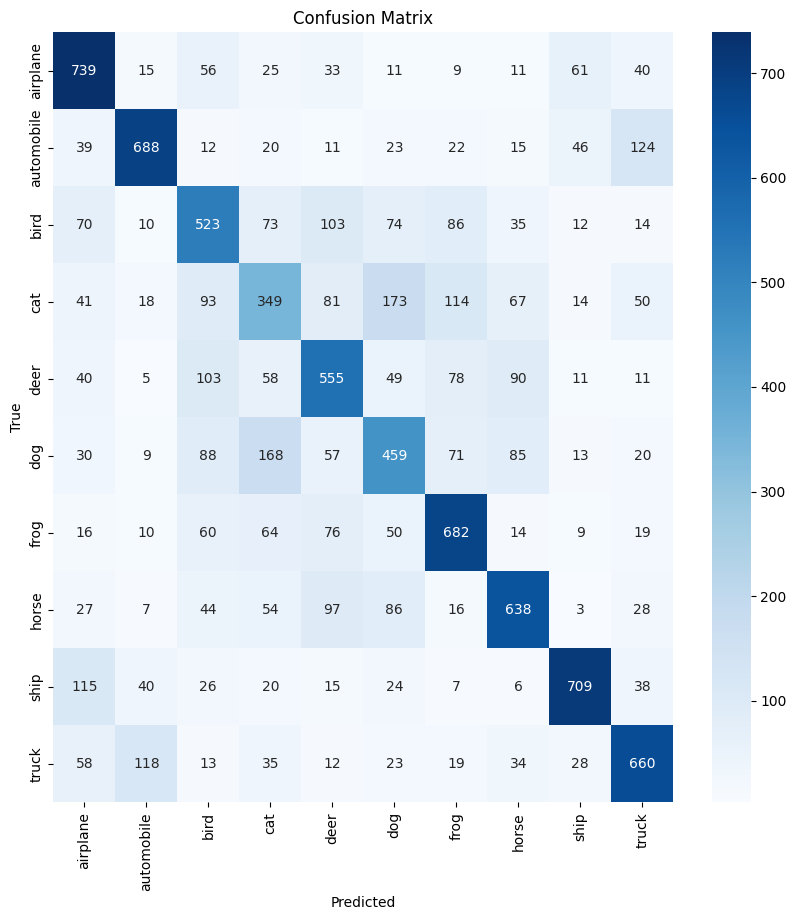

In [ ]:
model2.evaluate(X_test, y_test)
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_words.values(), yticklabels=label_words.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
history = model2.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9260 - loss: 0.2187 - val_accuracy: 0.9333 - val_loss: 0.1987
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9230 - loss: 0.2167 - val_accuracy: 0.9406 - val_loss: 0.1699
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9339 - loss: 0.1866 - val_accuracy: 0.9327 - val_loss: 0.1941
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9395 - loss: 0.1783 - val_accuracy: 0.9603 - val_loss: 0.1179
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9458 - loss: 0.1587 - val_accuracy: 0.9302 - val_loss: 0.2035


In [72]:

# TODO: Evaluate the testing performance
test_loss, test_acc = model2.evaluate(X_test, y_test)
test_acc, test_loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5896 - loss: 2.4138


(0.5910000205039978, 2.361875534057617)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5896 - loss: 2.4138
Test accuracy: 0.5910
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


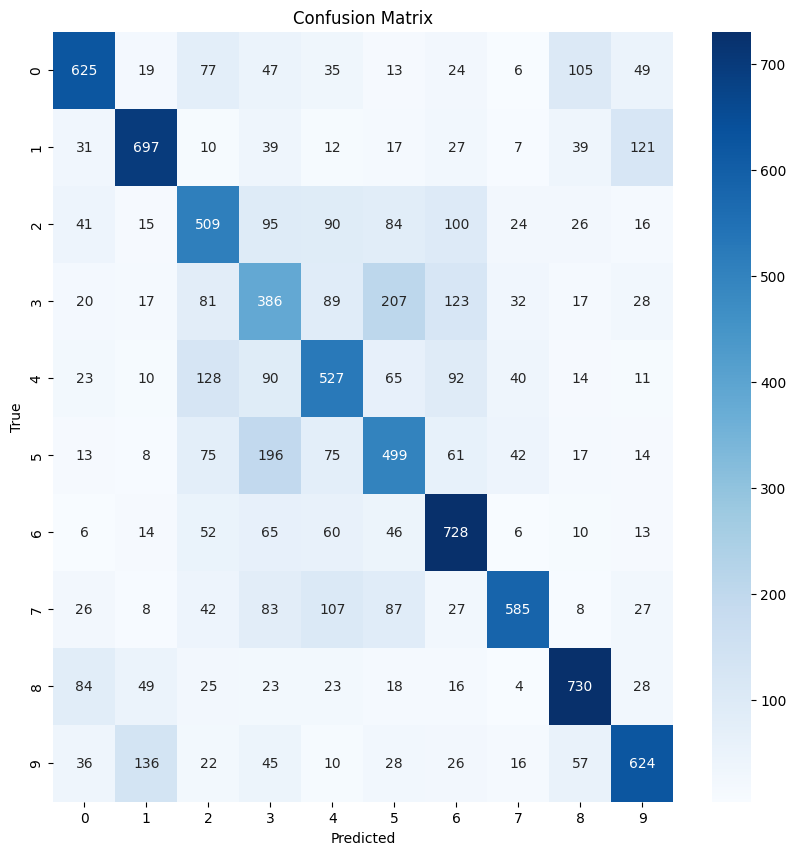

In [71]:
# save model
model2.save('best_model.keras')
# evaluate model
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
# predict model
y_pred = np.argmax(model2.predict(X_test), axis=1)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolution with dropout
model3 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=64, name='conv1'),
    keras.layers.MaxPooling2D(name='pool1'),
    DefaultConv2D(filters=128, name='conv2'),
    DefaultConv2D(filters=128, name='conv3'),
    keras.layers.MaxPooling2D(name='pool2'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(64, activation='relu', name='dense2', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model3.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)
history = model3.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.3375 - loss: 1.8240 - val_accuracy: 0.5356 - val_loss: 1.2925
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.5582 - loss: 1.2418 - val_accuracy: 0.6355 - val_loss: 1.0476
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.6292 - loss: 1.0490 - val_accuracy: 0.6989 - val_loss: 0.8574
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.6833 - loss: 0.9039 - val_accuracy: 0.7312 - val_loss: 0.7797
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.7190 - loss: 0.7954 - val_accuracy: 0.7696 - val_loss: 0.6712
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.7620 - loss: 0.6777 - val_accuracy: 0.8200 - val_loss: 0.5317
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.7973 - loss: 0.5777 - val_accuracy: 0.8206 - val_loss: 0.5246
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.8247 -

In [56]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
    ]

)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.8645 - loss: 0.3819 - val_accuracy: 0.9012 - val_loss: 0.2885 - learning_rate: 0.0100
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.8827 - loss: 0.3326 - val_accuracy: 0.8982 - val_loss: 0.2804 - learning_rate: 0.0100
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.8885 - loss: 0.3148 - val_accuracy: 0.9037 - val_loss: 0.2744 - learning_rate: 0.0100
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9000 - loss: 0.2846 - val_accuracy: 0.9369 - val_loss: 0.1817 - learning_rate: 0.0100
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9087 - loss: 0.2586 - val_accuracy: 0.9256 - val_loss: 0.2165 - learning_rate: 0.0100
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9158 - loss: 0.2464 - val_accuracy: 0.9096 - val_loss: 0.2604 - learning_rate: 0.0100
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accura

In [ ]:
# 3 and 5 labels only
X_train35, y_train35, X_valid35, y_valid35, X_test35, y_test35 = unpickle()

# dataframe
data = pd.DataFrame(X_train35)
data['label'] = y_train35
data = data[data['label'] == 3 | data['label'] == 5]
X_train = data.drop(columns=['label']).values
y_train = data['label'].values

data = pd.DataFrame(X_valid35)
data['label'] = y_valid35
data = data[data['label'] == 3 | data['label'] == 5]
X_valid = data.drop(columns=['label']).values
y_valid = data['label'].values

data = pd.DataFrame(X_test35)
data['label'] = y_test35
data = data[data['label'] == 3 | data['label'] == 5]
X_test = data.drop(columns=['label']).values
y_test = data['label'].values

# Reshape the data
X_train = np.array(X_train).reshape(-1, 32, 32, 3)
X_valid = np.array(X_valid).reshape(-1, 32, 32, 3)
X_test = np.array(X_test).reshape(-1, 32, 32, 3)
# Normalize the data
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0
# Reshape the labels
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# convolutional neural network
model4 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=32, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
    DefaultConv2D(filters=64, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(128, activation='relu', name='dense1'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model4.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model4.fit(
    X_train35, y_train35,
    epochs=10,
    validation_data=(X_valid35, y_valid35),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

ValueError: Unrecognized data type: x=[ 59  43  50 ... 140  84  72] (of type <class 'numpy.ndarray'>)